In [1]:
import os
from pathlib import Path

import geopandas as gpd
import pandas as pd

from nad.load import load_ageb_geometry

In [2]:
jobs_path = Path(os.environ["JOBS_PATH"])
population_grids_path = Path(os.environ["POPULATION_GRIDS_PATH"])
results_path = Path("./results")

In [3]:
df_geom_agebs = load_ageb_geometry(
    population_grids_path / "final" / "zone_agebs" / "shaped" / "2020" / "08.2.03.gpkg",
)

In [4]:
sector_map = {
    22: "Energía electrica, agua y gas",
    31: "Industrias manufactureras de alimentos textiles y tabaco",
    33: "Manufactureras de madera, papel, quimicos y plástico",
    56: "Electronicos maquinaria y equipo",
}

df_denue = (
    pd.read_csv(
        jobs_path / "denue_2023_estimaciones.csv",
        usecols=["codigo_act", "per_ocu", "latitud", "longitud"],
    )
    .assign(
        geometry=lambda df: gpd.points_from_xy(
            df["longitud"],
            df["latitud"],
            crs="EPSG:4326",
        ),
    )
    .assign(
        sector=lambda df: df["codigo_act"]
        .astype(str)
        .str[:2]
        .astype(int)
        .map(sector_map),
    )
    .dropna(subset=["sector"])
    .drop(columns=["latitud", "longitud", "codigo_act"])
    .rename(columns={"per_ocu": "empleos"})
)

df_denue = (
    gpd.GeoDataFrame(df_denue, geometry="geometry", crs="EPSG:4326")
    .to_crs(df_geom_agebs.crs)
    .sjoin(df_geom_agebs[["geometry"]], how="inner", predicate="within")
    .drop(columns=["CVEGEO"])
)

In [5]:
df_denue.to_crs("EPSG:4326").to_file(
    results_path / "platform" / "industrias_denue.geojson",
)

<Axes: >

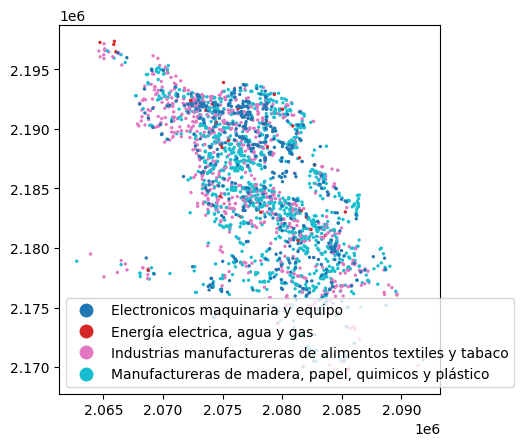

In [6]:
df_denue.plot(column="sector", categorical=True, legend=True, markersize=2)

In [8]:
df_denue.to_crs("EPSG:4326").to_file(
    results_path / "platform" / "industrias_denue.geojson",
)